## quelques simulations spectrales...

tout ça repose sur DOAS-basics, dispo ici:

https://gricad-gitlab.univ-grenoble-alpes.fr/voisind/doas-basics

In [23]:
%matplotlib inline
import sys, os
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob
from scipy import stats
#import hvplot
#import hvplot.pandas

!pwd

/Users/voisind/python_stuff/atmos_chem/DOAS-basics/work-notebooks


In [24]:
sys.path.append("../src/")
# ça, c'est si le notebook est dans un répertoire situé dans le répertoire DOAS-basics cloné depuis gricad
# si c'est ailleurs, alors remplacer la ligne précédente par: 

# sys.path.append("chemin_complet/DOAS-basics/src/")

from sun_pos import sza
import simulations as sims

In [25]:
hours = pd.date_range('2020-04-14 04:30:00', periods=25, freq='10T')


L'objectif de ce notebook est de simuler le spectre solaire arrivant au sol en un jour donné (14/04/2020) d'un endroit précis (maison de Mezon). Pour faire cela, nous allons  utiliser le spectre extrasolaire I0 mesuré depuis l'ISS et les sections efficaces des gaz comme O3, NO2, SO2, H2O, BrO, H2CO issues de HITRAN. Nous allons considérer une visée solaire directe dont le facteur d'amplification (ou AMF) est l'inverse du cosinus de l'angle solaire zénithal.

la structure du code est la suivante:

- 

- initialise_Xsect (wvl, resolution):
    - entree: 
        - wvl: vecteur de longueurs d'ondes équidistantes
        - resolution: la résolution (au sens largeur à mi-hauteur) souhaitée
    - sortie: dataFrame avec wvl comme index et toutes les Xsect bien réinterpolées
    - paramètres cachés = répertoire avec les Xsect et liste des gaz considérés

- initialise_solar (wvl, resolution):

- init_simul (wvl,resolution):

- calcul_irradiance (amf, col, Xsect):
    - entrée:
        - amf: facteur de masse d'air
        - col: dictionnaire des colonnes intégrées de gaz et aérosol
        - Xsect: df des sections efficaces; ça inclue l'index des lgrs d'ondes ou la simulation est faite
    - sortie:
        - un spectre (index= lgr d'onde, data= irradiance)

- calcul_amf (lon,lat,alt,dt):
    

In [34]:
res = 1 ; 
data_init = sims.init_simul(300,1000, res )
data_init.head()

solar            O3           NO2  SO2  H2O  O4  O2  H2CO  \
300.0  0.420177  3.929471e-19  1.170641e-19  NaN  NaN NaN NaN   NaN   
300.1  0.385418  3.884481e-19  1.159553e-19  NaN  NaN NaN NaN   NaN   
300.2  0.362419  3.837781e-19  1.149912e-19  NaN  NaN NaN NaN   NaN   
300.3  0.355761  3.792868e-19  1.144277e-19  NaN  NaN NaN NaN   NaN   
300.4  0.364663  3.750808e-19  1.144249e-19  NaN  NaN NaN NaN   NaN   

                BrO       tau         P  
300.0  2.788822e-18  2.011520  0.055451  
300.1  2.574626e-18  2.010702  0.055377  
300.2  2.380869e-18  2.009885  0.055303  
300.3  2.207573e-18  2.009068  0.055230  
300.4  2.060300e-18  2.008252  0.055156

<AxesSubplot:>

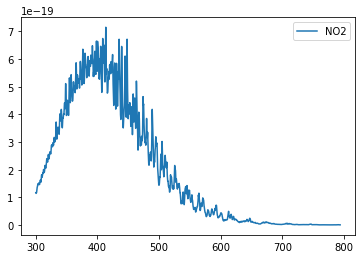

In [39]:
#data_init.to_csv('data_init_res'+str(res)+'nm.csv')

data_init.plot(y=['NO2'])

NO2 se détecte bien entre 400 et 500nm

# Fonction de simulation

In [28]:
'''
cd= column_density
Reference: Towards imaging of atmospheric trace gases using Fabry-Perot 
interferometer correlation spectroscopy in the uv and visible spectral range
unit = molecules / cm2
rq: NO2 and SO2 values are high, typical of a very polluted spot
'''

def P(z):
    H0 = 8500 #m 
    P0 = 1 # atm
    return P0*np.exp(-z/H0) # atm


#exemple de calcul avec juste les gaz
cd = {'O3':1e20, 
      'NO2':1e17, 
      'SO2':3e18, 
      'H2O':2e22, 
      'BrO':1e14, 
      'O4':1e43,
      'O2':1e60,
      'H2CO':6e15}

#      'CHOCHO':4e14,

"""
#exemple de calul avec diffusion rayleigh et aérosols
cd = {'O3':1e20, 
      'NO2':1e17, 
      'SO2':3e18, 
      'H2O':2e22, 
      'BrO':1e14, 
      'O4':1e43,
      'tau':0.2,    
      'O2':1e60,
      'H2CO':6e15,
      'P': P(200)}
"""




def simulation(df,cd,AMF):
    '''Cette fonction permet de simuler le spectre solaire atteignant le sol.
    I0 = spectre extrasolaire
    T = Combinaison lineaire des conc et des xsect
    I = Intensité solaire qui arrive au sol'''
    dff = df[['solar']].copy()
    dff.rename(columns ={'solar':'I0_solar'}, inplace=True)

    T = pd.concat([ df[gas]*cd[gas] for gas in cd ], axis='columns') \
          .sum(axis='columns')
    T.plot(logy=True)

    dff['I_sol'] = dff['I0_solar'] * np.exp(- AMF * T)
    dff['vod'] = T
    return dff


42.54065719810059 1.3572245552159565


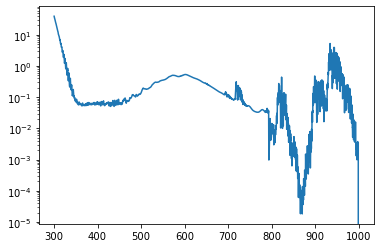

In [29]:
angle = sza(pd.to_datetime('2020-04-15 13:30'))
amf = sims.amf_straight(angle)
print(angle, amf)
df = simulation(data_init,cd,1)

In [31]:
df.head()

I0_solar         I_sol        vod
300.0  0.420177  3.570693e-18  39.306693
300.1  0.385418  5.136857e-18  38.856664
300.2  0.362419  7.706248e-18  38.389546
300.3  0.355761  1.185432e-17  37.940342
300.4  0.364663  1.850465e-17  37.519728

<AxesSubplot:>

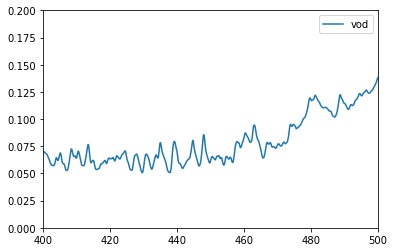

In [40]:
#ax = df.plot(y=['I0_solar','I_sol'])
df.plot(y='vod',ylim=(0,0.2), xlim=(400,500))#,ax=ax,secondary_y=True)


clairement, si on veut voir NO2 (entre 400 et 500nm), il faut être en mesure de différentier du bruit des variations de od de l'ordre de 0.02 d'une longueur d'onde à l'autre pour une amf de 1.

au zénith en soleil rasant, on a une amf > 10, et on doit s'en sortir avec 0.2

or, $od = ln\left(spectre_{ref}\right) - ln\left(spectre_{mes}\right) $

soit: $\delta od \approx \sqrt 2 ~ \delta  ln\left(spectre_{mes}\right) = \sqrt 2 {\delta spectre_{mes} \over spectre_{mes}}$

donc le bruit de mesure sur od peut être estimé par le bruit de mesure spectroscopique !

et pour une mesure OK NO2, il faut donc un bruit sur la mesure spectrale inférieur à 1% en lumière rasante, et inférieur à 0.1% en occultation solaire

waouh !!!!

In [23]:

hours = pd.date_range('2020-04-14 05:30:00', periods=25, freq='30T')
results=[]

for hour in hours:
    SZA = sza(hour,location='mezon')
    AMF = sims.amf_straight(SZA)
    result = sims.simulation(data_init,cd,AMF).reset_index().rename({'index':'wvl'},axis='columns')
    result['AMF'] = AMF
    result['datetime'] = hour
    results += [result]

stacked = pd.concat(results)
stacked

wvl  I0_solar     I_sol       AMF            datetime
0      300.0  0.420177  0.004939  9.734639 2020-04-14 05:30:00
1      300.1  0.385418  0.004541  9.734639 2020-04-14 05:30:00
2      300.2  0.362419  0.004280  9.734639 2020-04-14 05:30:00
3      300.3  0.355761  0.004211  9.734639 2020-04-14 05:30:00
4      300.4  0.364663  0.004326  9.734639 2020-04-14 05:30:00
...      ...       ...       ...       ...                 ...
13995  999.5       NaN       NaN  6.852377 2020-04-14 17:30:00
13996  999.6       NaN       NaN  6.852377 2020-04-14 17:30:00
13997  999.7       NaN       NaN  6.852377 2020-04-14 17:30:00
13998  999.8       NaN       NaN  6.852377 2020-04-14 17:30:00
13999  999.9       NaN       NaN  6.852377 2020-04-14 17:30:00

[350000 rows x 5 columns]

In [24]:
filename = 'Irradiance_'+str(res)+'nm.csv'
stacked.to_csv(filename,index=None)